# 构建检索增强生成 (RAG) 应用程序
LLM 所实现的最强大的应用之一是复杂的问答 (Q&A) 聊天机器人。这些应用程序可以回答有关特定源信息的问题。这些应用程序使用一种称为检索增强生成 (RAG) 的技术。

本教程将介绍如何基于文本数据源构建一个简单的问答应用程序。在此过程中，我们将介绍典型的问答架构，并重点介绍更多高级问答技术的资源。我们还将了解 LangSmith 如何帮助我们跟踪和理解我们的应用程序。随着我们的应用程序变得越来越复杂，LangSmith 将变得越来越有用。

如果您已经熟悉基本检索，您可能还会对不同检索技术的高级概述感兴趣。

## 什么是 RAG 
RAG 是一种利用附加数据增强 LLM 知识的技术。

LLM 可以推理广泛的主题，但他们的知识仅限于他们接受训练的特定时间点的公共数据。如果您想构建能够推理私有数据或模型截止日期后引入的数据的 AI 应用程序，则需要使用模型所需的特定信息来增强模型的知识。将适当的信息引入模型提示的过程称为检索增强生成 (RAG)。

LangChain 有许多组件，旨在帮助构建问答应用程序以及更广泛的 RAG 应用程序。

注意：这里我们专注于非结构化数据的问答。如果您对结构化数据的 RAG 感兴趣，请查看我们关于通过 SQL 数据进行问答的教程。

典型的 RAG 应用程序有两个主要组件：

1. 索引：从源中提取数据并对其进行索引的管道。这通常在线下进行。

2. 检索和生成：实际的 RAG 链，它在运行时接受用户查询并从索引中检索相关数据，然后将其传递给模型。

从原始数据到答案最常见的完整序列如下：
- 加载：首先我们需要加载数据。这可以通过文档加载器完成。
- 拆分：文本拆分器将大块内容拆分Documents成小块内容。这对于索引数据和将数据传递到模型都很有用，因为大块内容更难搜索，并且不适合模型的有限上下文窗口。
- 存储：我们需要一个地方来存储和索引我们的分割，以便以后可以搜索它们。这通常使用VectorStore和Embeddings模型来完成。

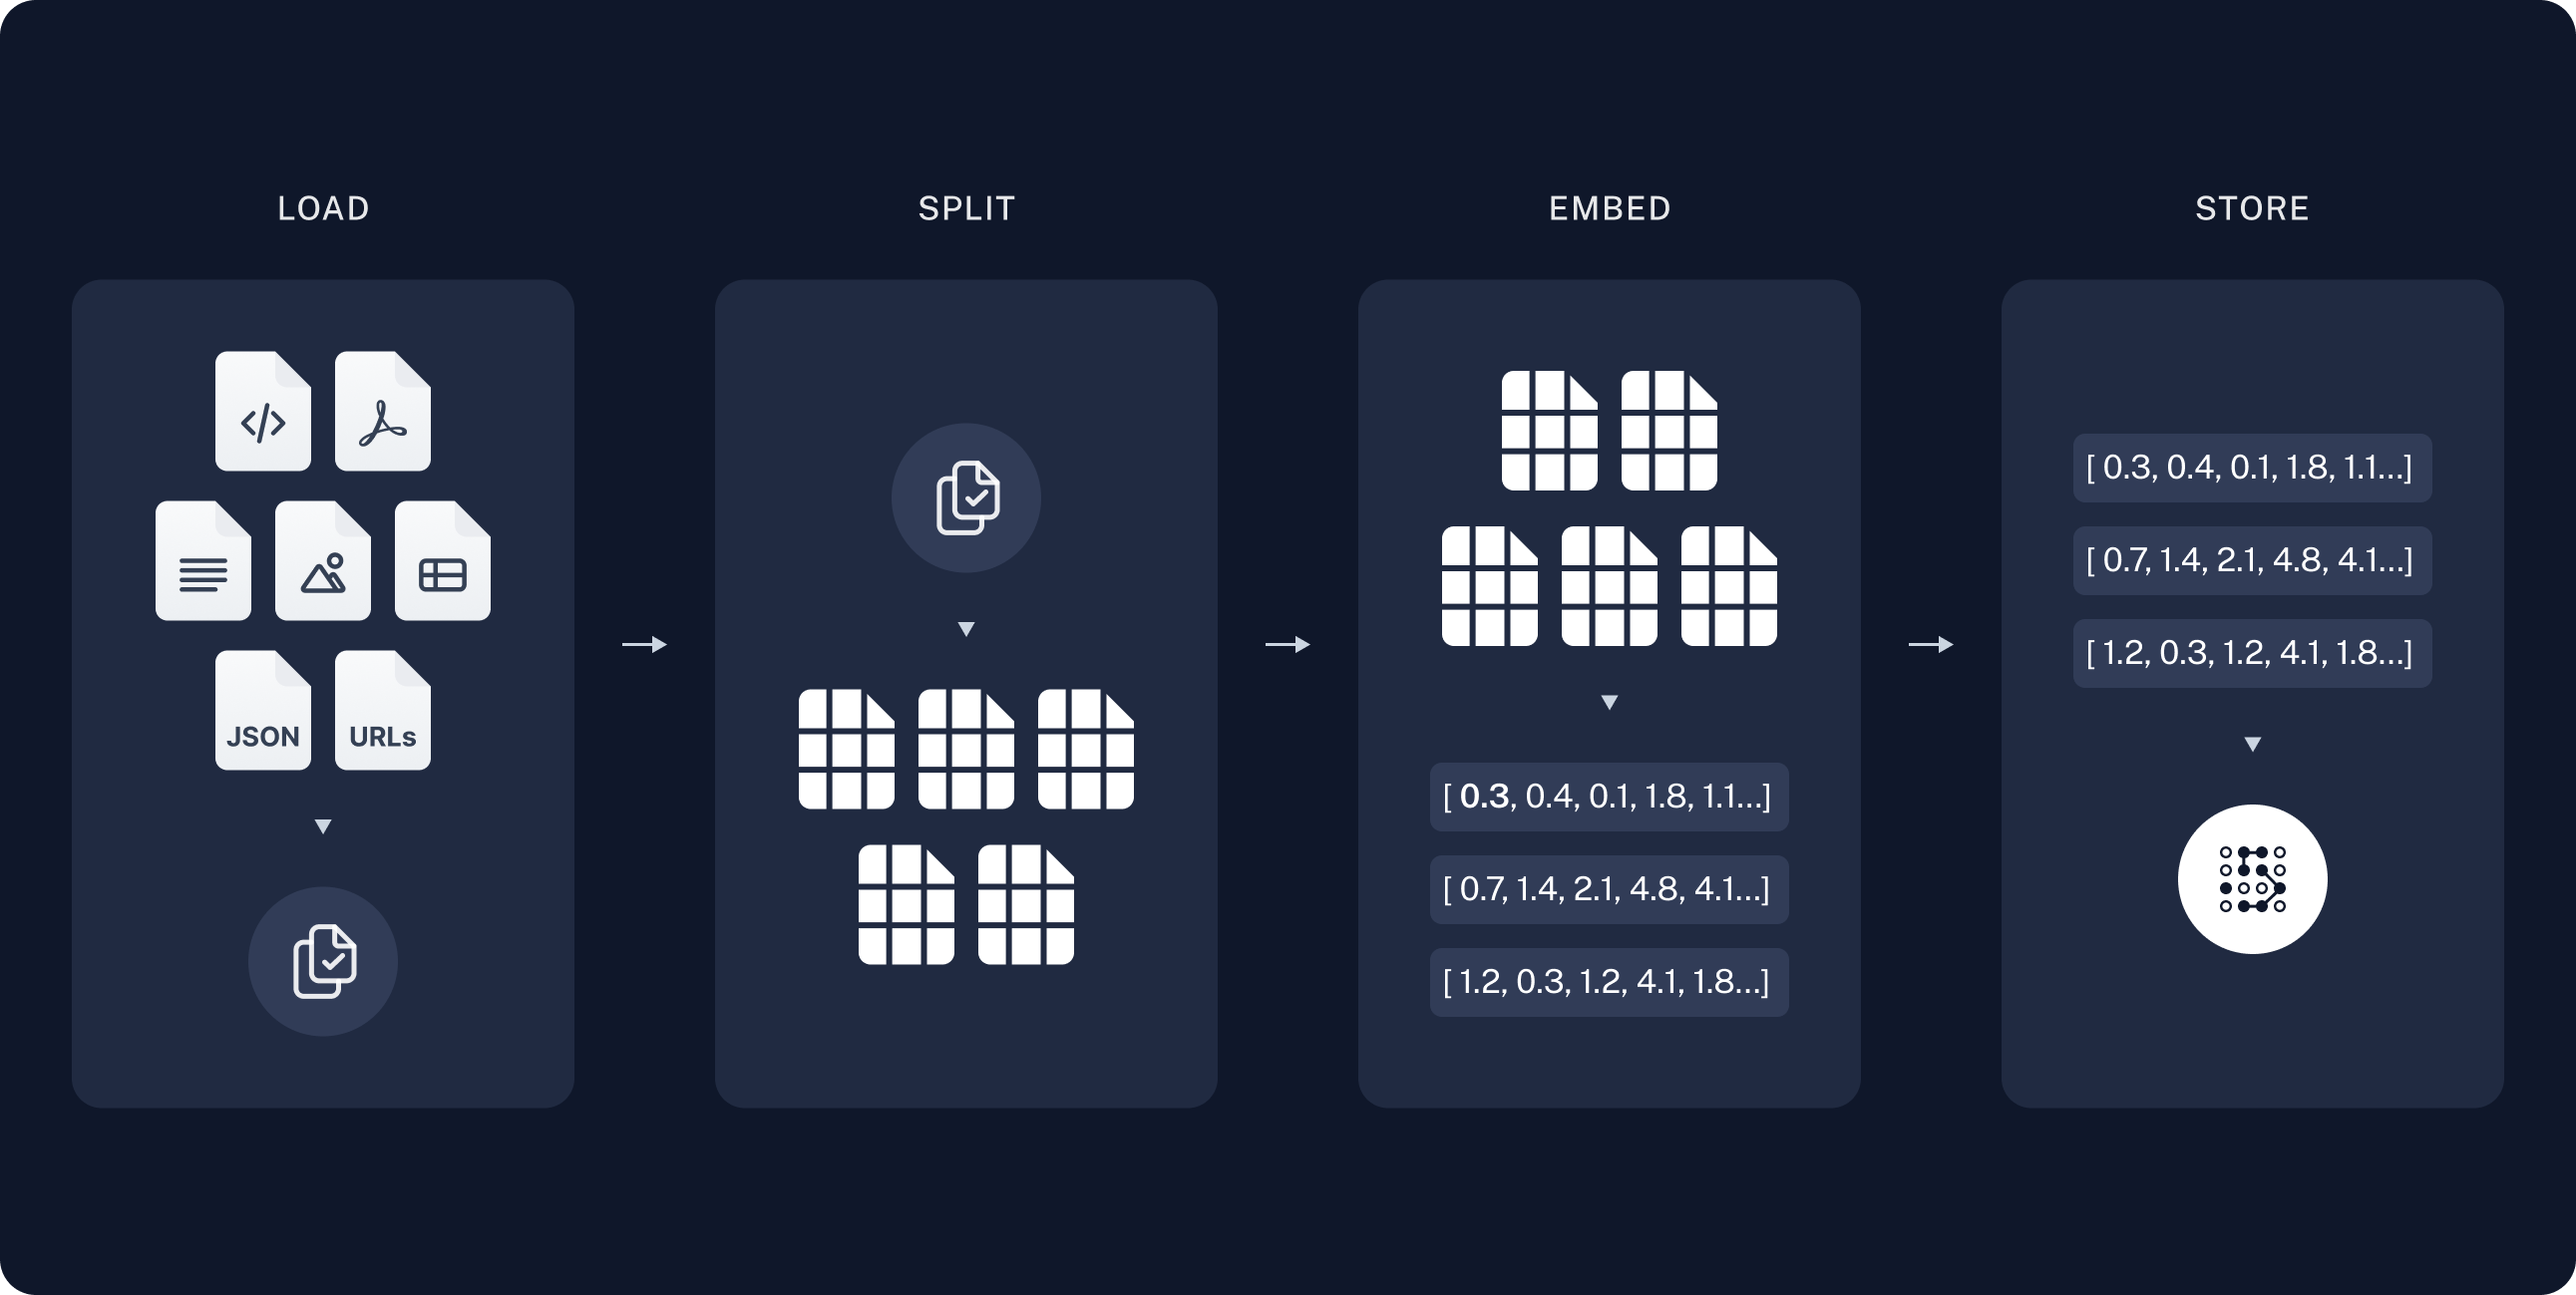

### 检索和生成
- 检索：根据用户输入，使用检索器从存储中检索相关分割。
- 生成：ChatModel / LLM使用包含问题和检索到的数据的提示生成答案

In [1]:
from dotenv import load_dotenv, find_dotenv
from langchain.globals import set_debug

load_dotenv(find_dotenv())
set_debug(False)




In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
)



In [3]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

USER_AGENT environment variable not set, consider setting it to identify your requests.


'Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This approach allows agents or models to tackle difficult tasks more effectively by dividing them into manageable parts. Task decomposition can be done through prompting techniques like Chain of Thought or Tree of Thoughts, as well as with task-specific instructions or human inputs.'